# Comparing two normal distributions (with random effects)

In [3]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('dark')

# Statistical modelling
import pymc3 as pm

import theano 
import theano.tensor as tt

import patsy
import scipy.stats as st

In [4]:
# filter some annoying warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
# Set seed of the random number generator for reproducibility
SEED = 880123

## The story

![traffic](..\images\traffic.jpg)

> Let's image that you have collected some data on highway driving. Some people were driving manually, whereas some others were using adaptive cruise control (ACC). You want to investigate if there is any difference in speed between manual driving and driving with ACC. The hypothesis is that ACC, by automating the longitudinal control of the car, will have an impact on the speed people travel at.

## Generate artificial data

In [26]:
n_driving_mode = 2
n_drivers = 5
n_samples_per_driving_mode = 150

within_driver_sd = np.array([2, 0.5])
between_driver_sd = np.array([2, 1])

In [27]:
drivers = ['Driver_{:02}'.format(i+1) for i in range(n_drivers)]

In [28]:
mu_fixed_effect = np.array([100, 100])

In [29]:
# I draw the mu for each driver
mu_driver = np.random.normal(loc=mu_fixed_effect, scale=between_driver_sd, size=(n_drivers, n_driving_mode))

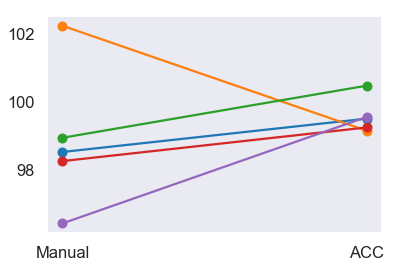

In [30]:
plt.plot(np.array([0, 1]), mu_driver.T, marker='o');
plt.xticks([0, 1], (['Manual', 'ACC']))
pass

In [31]:
#draw observations around the mean for each driver and each driving mode
obs = np.random.normal(loc=mu_driver, scale=within_driver_sd, size=(n_samples_per_driving_mode, n_drivers, n_driving_mode))
obs.shape

(150, 5, 2)

In [32]:
obs.flatten(order='F').shape

(1500,)

In [33]:
np.tile(drivers, reps=n_samples_per_driving_mode*n_driving_mode).shape

(1500,)

In [34]:
np.concatenate((np.zeros(n_samples_per_driving_mode*n_drivers), np.ones(n_samples_per_driving_mode*n_drivers))).shape

(1500,)

In [35]:
data = pd.DataFrame(
        {
            'speed':np.concatenate((obs[:, :, 0].flatten(order='C'), obs[:, :, 1].flatten(order='C'))),
            'driver':np.tile(drivers, reps=n_samples_per_driving_mode*n_driving_mode),
            'ACC_active':np.concatenate((np.zeros(n_samples_per_driving_mode*n_drivers), np.ones(n_samples_per_driving_mode*n_drivers)))
        }

)

In [36]:
data['ACC_active'] = data['ACC_active'].astype('int')
data['driver'] = data['driver'].astype('category')

In [37]:
data.head()

,speed,driver,ACC_active
0,97.277015,Driver_01,0
1,99.070631,Driver_02,0
2,99.239389,Driver_03,0
3,96.122162,Driver_04,0
4,96.276409,Driver_05,0


([<matplotlib.axis.XTick at 0x2d5eabd2e48>,
 <a list of 2 Text xticklabel objects>)

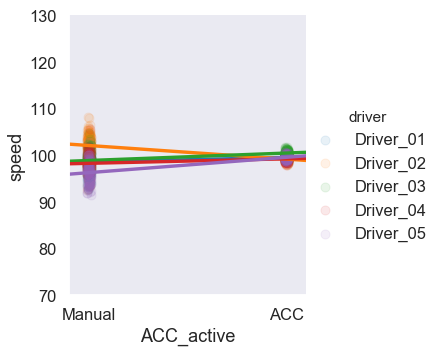

In [38]:
sns.lmplot(x='ACC_active', y='speed', hue='driver', data=data, ci=None, x_jitter=0.01, scatter_kws=dict(alpha=0.1))
plt.xlim((-0.1, 1.1))
plt.ylim((70, 130))
plt.xticks([0, 1], (['Manual', 'ACC']))

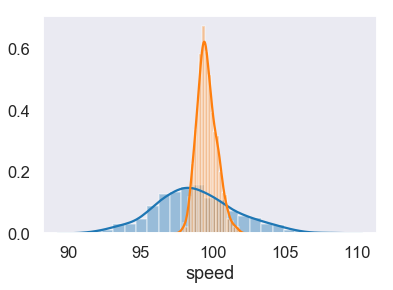

In [39]:
sns.distplot(data.loc[data['ACC_active']==0, 'speed'])
sns.distplot(data.loc[data['ACC_active']==1, 'speed'])

In [40]:
data.groupby('ACC_active').agg(['mean', 'std'])

speed          
                 mean       std
ACC_active                     
0           98.799563  2.781909
1           99.589667  0.672239

A first look suggests that manual driving has higher speed variability than ACC driving. Moreover, it seems that, on average, the speed is lower in manual driving than in ACC driving. A possible explanation is that the activation of ACC reduce the human variability in maintaining the speed and the headway to the lead vehicle.

We will estimate the difference in average speed and variability with Bayesian modelling. Thanks to the Bayesian method we will also obtain the uncertainty of the estimation. 

## Bayesian modelling

In [41]:
X = patsy.dmatrix('1 + ACC_active', data=data)
Z_intercept = patsy.dmatrix('0 + driver', data=data)
Z_slope = patsy.dmatrix('0 + driver:ACC_active', data=data)
X.shape, Z_intercept.shape, Z_slope.shape

((1500, 2), (1500, 5), (1500, 5))

In [42]:
X[:10, :]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [43]:
Z_intercept[:10, :]

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [44]:
Z_slope[550:560, :]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [45]:
data.head()

,speed,driver,ACC_active
0,97.277015,Driver_01,0
1,99.070631,Driver_02,0
2,99.239389,Driver_03,0
3,96.122162,Driver_04,0
4,96.276409,Driver_05,0


In [47]:
# Sampler settings
BURNIN=1000
TUNE=2500
SAMPLES=2000

### Build the model

In [48]:
with pm.Model() as model:
    
    ## Fixed effect
    # Prior on 'mu'
    beta_mu_intercept = pm.Normal('beta_mu_intercept', mu=data['speed'].mean(), sd=25)
    beta_mu_slope = pm.Normal('beta_mu_slope', mu=0, sd=5)
    beta_mu = tt.stack(beta_mu_intercept, beta_mu_slope)
    
    ## Random effect
    # mu
    gamma_mu_intercept_sd = pm.HalfNormal('gamma_mu_intercept_sd', sd=50)
    gamma_mu_intercept_raw = pm.Normal('gamma_mu_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    gamma_mu_intercept = pm.Deterministic('gamma_mu_intercept', gamma_mu_intercept_raw * gamma_mu_intercept_sd)
    
    gamma_mu_slope_sd = pm.HalfNormal('gamma_mu_slope_sd', sd=50)
    gamma_mu_slope_raw = pm.Normal('gamma_mu_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_mu_slope = pm.Deterministic('gamma_mu_slope', gamma_mu_slope_raw * gamma_mu_slope_sd)  
    
    tt.printing.Print('beta_mu')(beta_mu)
    tt.printing.Print('gamma_mu_intercept')(gamma_mu_intercept)
    tt.printing.Print('gamma_mu_slope')(gamma_mu_slope)
    
    mu = tt.dot(np.asarray(X), beta_mu) + \
         tt.dot(np.asarray(Z_intercept), gamma_mu_intercept) + \
         tt.dot(np.asarray(Z_slope), gamma_mu_slope)

    tt.printing.Print('mu')(mu.shape)

    # Prior on 'sd'
    #beta_sd = pm.Normal('beta_sd', mu=0, sd=0.5, shape=X.shape[1])
    #sd = tt.sqrt(tt.exp(tt.dot(np.asarray(X), beta_sd)))
    sd = pm.HalfNormal('sd', sd=10)
    # sd
    #gamma_sd_intercept_sd = pm.HalfNormal('gamma_sd_intercept_sd', sd=0.5)
    #gamma_sd_intercept_raw = pm.Normal('gamma_sd_intercept_raw', mu=0, sd=1, shape=Z_intercept.shape[1])
    #gamma_sd_intercept = pm.Deterministic('gamma_sd_intercept', gamma_sd_intercept_raw * gamma_sd_intercept_sd)
    
    """
    gamma_sd_slope_sd = pm.HalfNormal('gamma_sd_slope_sd', sd=5)
    gamma_sd_slope_raw = pm.Normal('gamma_sd_slope_raw', mu=0, sd=1, shape=Z_slope.shape[1])
    gamma_sd_slope = pm.Deterministic('gamma_sd_slope', gamma_sd_slope_raw * gamma_sd_slope_sd)  

    sd = tt.sqrt(tt.exp(tt.dot(np.asarray(X), beta_sd) + \
                        tt.dot(np.asarray(Z_intercept), gamma_mu_intercept) + \
                        tt.dot(np.asarray(Z_slope), gamma_mu_slope)))"""
    
    #sd = tt.sqrt(tt.exp(tt.dot(np.asarray(X), beta_sd) + \
    #                    tt.dot(np.asarray(Z_intercept), gamma_mu_intercept)))
    
    ## Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sd=sd, observed=data['speed'].values)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '2420' (I am process '11840')


beta_mu __str__ = [99.19461492  0.        ]
gamma_mu_intercept __str__ = [0. 0. 0. 0. 0.]
gamma_mu_slope __str__ = [0. 0. 0. 0. 0.]
mu __str__ = [1500]


In [49]:
model.check_test_point()

beta_mu_intercept                -4.14
beta_mu_slope                    -2.53
gamma_mu_intercept_sd_log__      -0.77
gamma_mu_intercept_raw           -4.59
gamma_mu_slope_sd_log__          -0.77
gamma_mu_slope_raw               -4.59
sd_log__                         -0.77
likelihood                    -4543.62
Name: Log-probability of test_point, dtype: float64

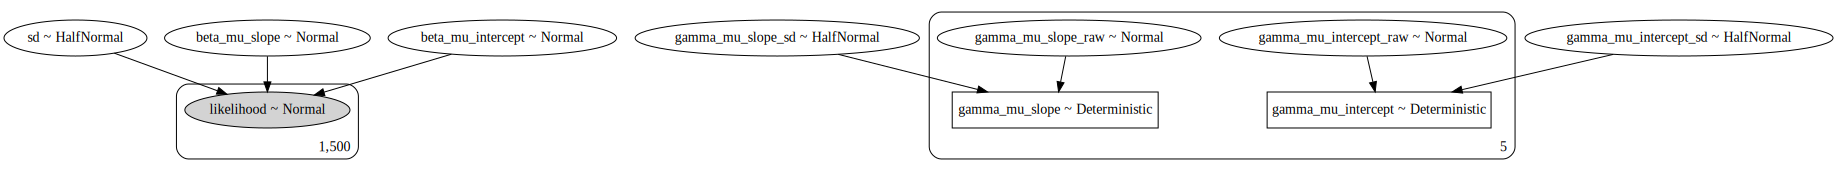

In [50]:
pm.model_to_graphviz(model)

### Sample from the model

In [51]:
with model:
    trace = pm.sample(draws=SAMPLES+BURNIN, tune=TUNE, init='jitter+adapt_diag', chains=4, cores=4, random_seed=SEED, nuts_kwargs={'target_accept':0.99})

# discard burnin samples
trace = trace[BURNIN:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, gamma_mu_slope_raw, gamma_mu_slope_sd, gamma_mu_intercept_raw, gamma_mu_intercept_sd, beta_mu_slope, beta_mu_intercept]
Sampling 4 chains: 100%|████████████████████████████████████████| 22000/22000 [39:39<00:00,  7.15draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


### Diagnose the sampling

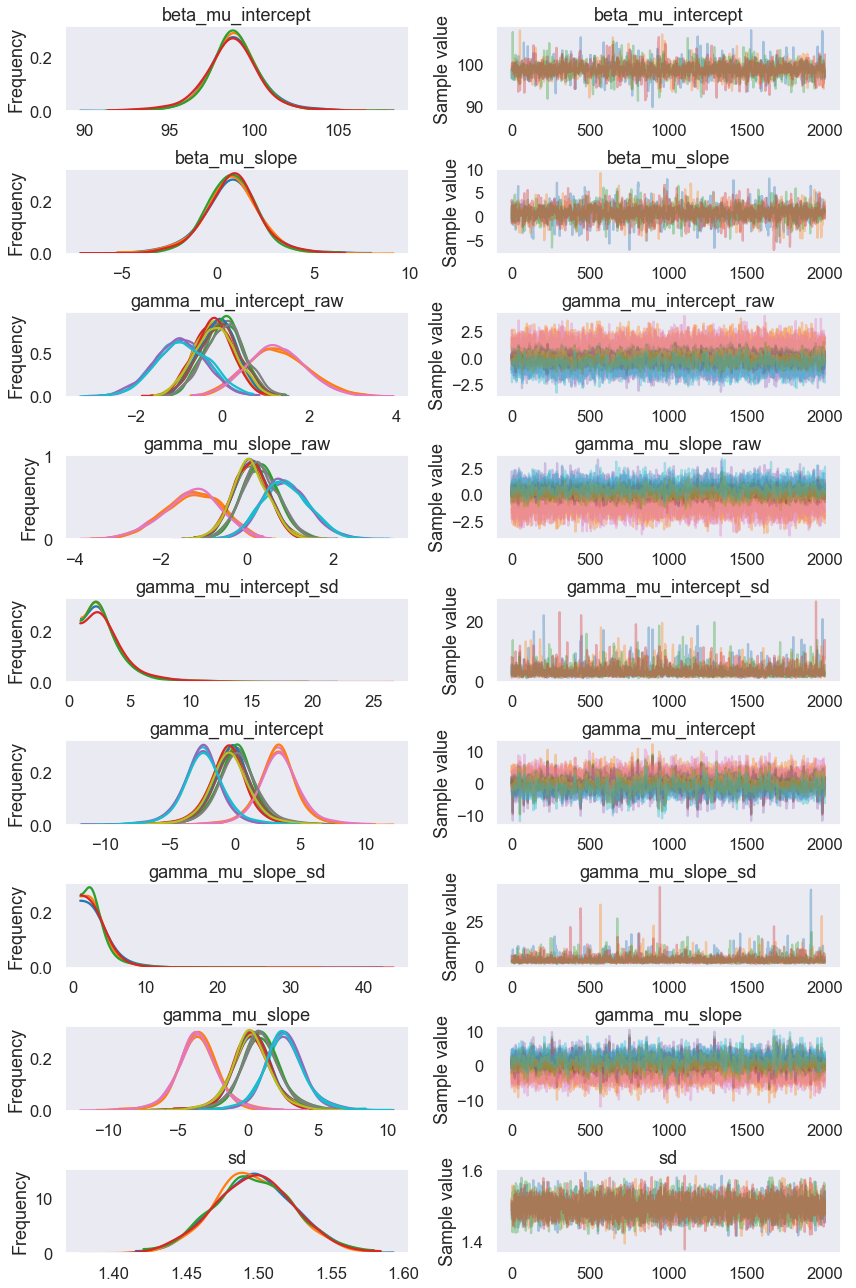

In [52]:
pm.traceplot(trace);

### Summarize the posterior density

In [ ]:
pm.summary(trace).round(2)

### Posterior predictive check

In [ ]:
fig, ax = plt.subplots()

THIN = 100
X = np.arange(50, 150, 0.5)

for cat in data.driving_mode.cat.categories:
    sns.distplot(data[data.driving_mode==cat].speed, norm_hist=True, kde=False, label=cat, hist_kws={'histtype':'stepfilled'})

for i, group in enumerate(data['driving_mode'].cat.categories): 
    for mu, sd in zip(trace['mu'][::THIN, i], trace['sd'][::THIN, i]):
        ax.plot(X, st.norm.pdf(x=X, loc=mu, scale=sd), alpha=0.1, color=sns.color_palette()[i])

plt.legend();

The posterior predictive check suggests that our model generates credible observations, because the fit agrees well with the experimental data.

## Statistical inference

In [ ]:
pm.plot_posterior(trace, varnames=['delta_mu', 'delta_sd'], ref_val=0, round_to=1, kde_plot=True, lw=5);

Our research question was on the quantification of the difference in speed between manual driving and ACC driving. Given the data and our model, we can say that, on average, people driving with ACC maintained a speed 10km/h than in manual driving. Moreover, the ACC decreased the variability in speed compared to manual driving.

The higher posterior density (HPD) interval can be interpreted in probabilistic way. That is, we can state that, given our data and the model, there is 95% probability that the difference in average speed is between 8.0 and 12.2 km/h.